# Portfolio Strategy Analysis: CPPI vs Buy & Hold

## Research Question
Does a **CPPI** outperform a **Buy & Hold** benchmark over the sample period ***[2000-2023]*** in terms of risk-adjusted performance?

## Strategy Chosen
- Strategy type: **CPPI**
- Assets analyzed: **S&P 500, SPY**
- Rebalancing frequency: **[weekly/monthly]**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import importlib
import utils
importlib.reload(utils)
from utils import *

import yfinance as yf
from datetime import datetime

## Data Import
We import price data for the following tickers:

- **S&P 500**
- **S&P U.S. Treasury Bill Index**  
- Period: **[01/01/2000 – 31/12/2023]**

In [3]:
tickers = ["SPY", "SHY"]  # S&P 500 ETF and S&P U.S. Treasury Bill Index (made of T-bills with a 1-year or less maturity)
start = "2003-01-01"
end = "2025-10-31"

all_data = {}

for ticker in tickers:
    all_data[ticker] = download_or_load(ticker, start, end)

# Optional: clear all CSV files if needed
# clear_all_csv()

[LOAD DATA] SPY already saved. Loading from CSV...
[LOAD DATA] SHY already saved. Loading from CSV...


## Raw Price Series
We plot the raw adjusted close prices to visually inspect data quality.

In [4]:
DATA_FOLDER = "../data"
all_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(".csv")]

all_data = {}

for file in all_files:
    ticker = file.replace(".csv", "")
    
    # Skip the first 2 rows which are extra headers from yfinance
    df = pd.read_csv(
        os.path.join(DATA_FOLDER, file),
        skiprows=2,         # Skip extra rows
        parse_dates=["Date"],
        index_col="Date"
    )
    
    # Rename the single column to ticker
    df.columns = [ticker]
    
    all_data[ticker] = df

# Combine all tickers
prices = pd.concat(all_data.values(), axis=1)

print(prices.head())

                  SHY        SPY
Date                            
2003-01-02  53.461082  59.820522
2003-01-03  53.467648  60.004463
2003-01-06  53.435043  61.062004
2003-01-07  53.474163  60.910942
2003-01-08  53.519768  60.030731


## Data Cleaning
- Handle missing values  
- Check for price jumps  
- Convert prices to log or simple returns

Jumps detected in the following tickers and day:
                 SHY       SPY
Date                          
2008-10-13 -0.004406  0.145197
2008-10-28  0.001191  0.116855
2020-03-16  0.001622 -0.109423
2025-04-09 -0.000605  0.105019


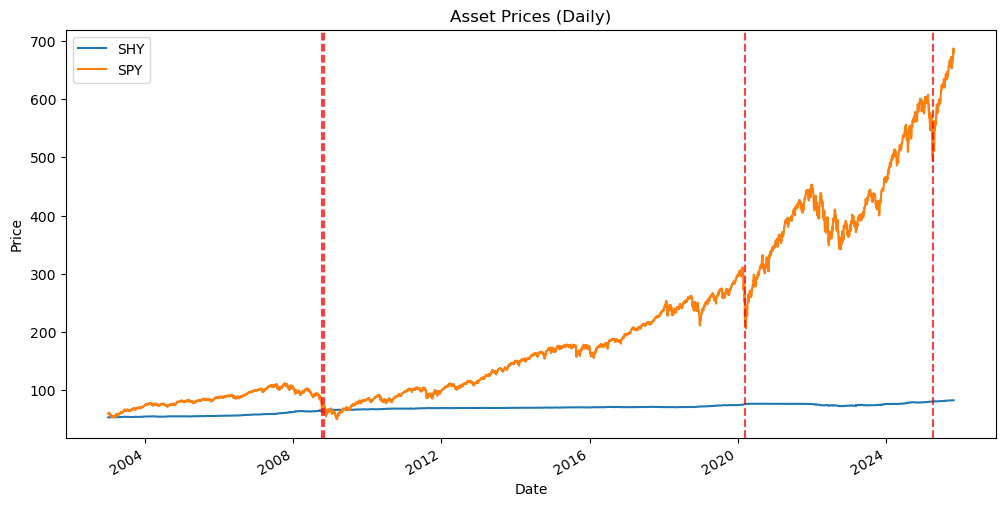

In [5]:
# Missing value handling
prices = prices.dropna()

# Log returns
returns = prices.pct_change().dropna()
returns.head()

# Weekly returns
# returns = prices.resample('W').last().pct_change().dropna()

# Check for jumps in the data
jumps = (np.abs(returns) > 0.10)
jump_days = jumps.any(axis=1)
print("Jumps detected in the following tickers and day:")
print(returns[jump_days])

# Plot prices
prices.plot(title="Asset Prices (Daily)", figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price")
for date in jump_days[jump_days].index:
    plt.axvline(date, color='red', linestyle='--', alpha=0.75)
plt.show()

## Return Properties
We inspect return behavior: distribution, volatility, etc.

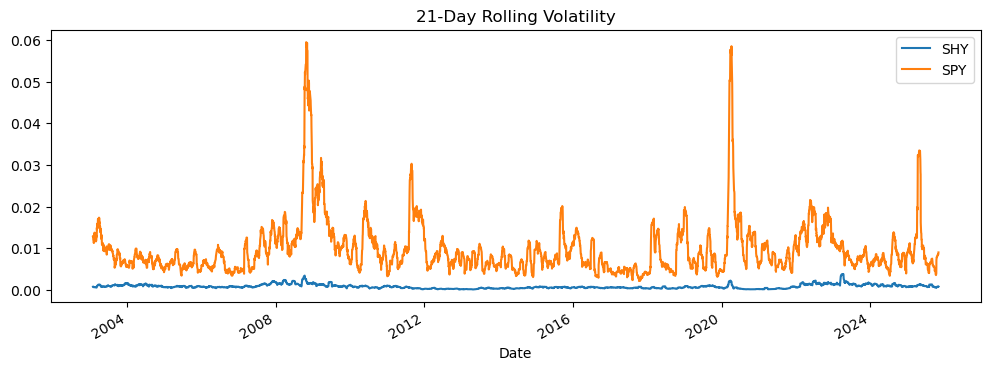

Annualized Volatility:
SHY    0.015164
SPY    0.187037
dtype: float64


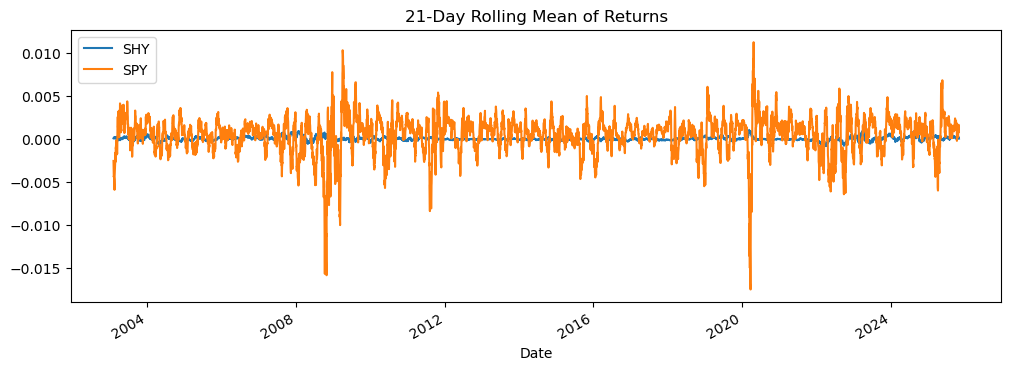

ACF for SHY


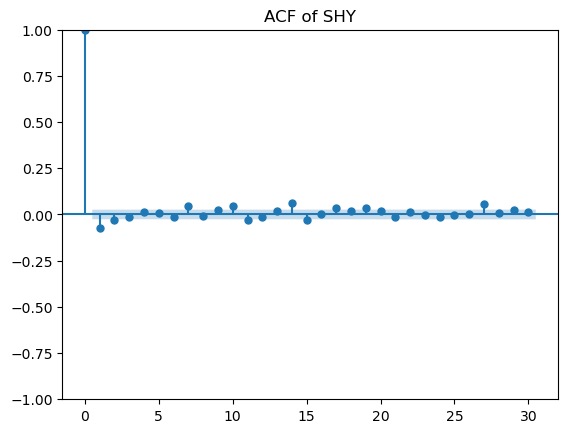

ACF for SPY


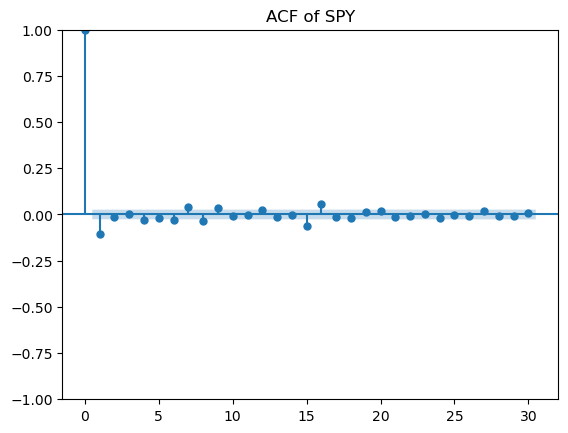

ACF of squared returns for SHY


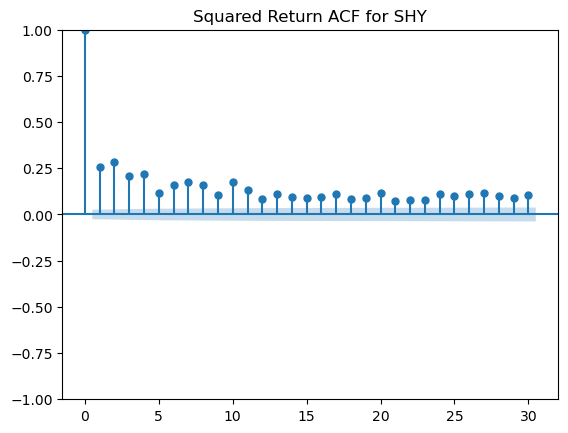

ACF of squared returns for SPY


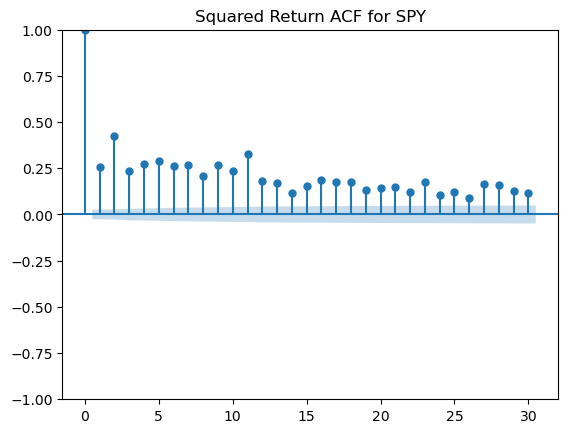

Skewness:
SHY    0.330138
SPY   -0.005244
dtype: float64
Kurtosis:
SHY     7.393631
SPY    15.288155
dtype: float64
Correlation matrix:
          SHY       SPY
SHY  1.000000 -0.225216
SPY -0.225216  1.000000
Jump frequency per asset:
SHY    0.000000
SPY    0.000696
dtype: float64
Global jump days:
DatetimeIndex(['2008-10-13', '2008-10-28', '2020-03-16', '2025-04-09'], dtype='datetime64[ns]', name='Date', freq=None)


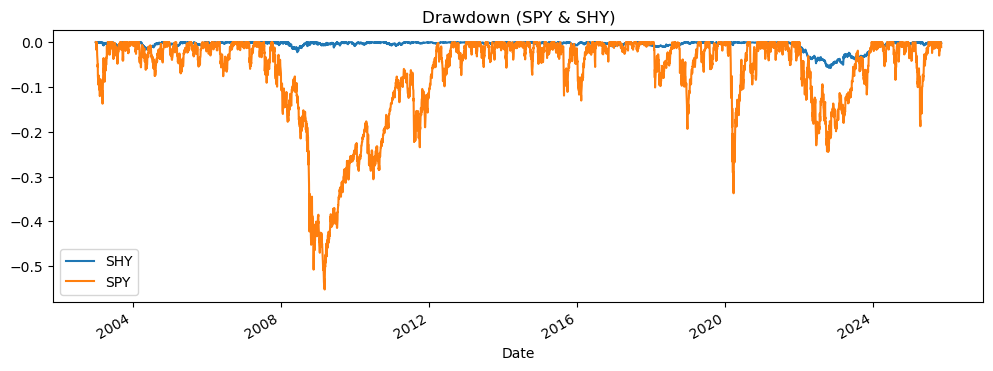

Sharpe Ratios:
SHY    0.000000
SPY    0.560884
dtype: float64


,SHY,SPY
Date,,
2003-01-03,0.000123,0.003075
2003-01-06,-0.000610,0.017624
2003-01-07,0.000732,-0.002474
2003-01-08,0.000853,-0.014451
2003-01-09,-0.001827,0.015538


In [6]:
# Rolling volatility (21-day)
roll_vol = returns.rolling(21).std()
roll_vol.plot(figsize=(12,4), title="21-Day Rolling Volatility")
plt.show()

# Annualized volatility
ann_vol = returns.std() * np.sqrt(252)
print("Annualized Volatility:")
print(ann_vol)

# Rolling mean (21-day)
roll_mean = returns.rolling(21).mean()
roll_mean.plot(figsize=(12,4), title="21-Day Rolling Mean of Returns")
plt.show()

# Autocorrelation plot, is previous return correlated with current return?
for col in returns.columns:
    print(f"ACF for {col}")
    sm.graphics.tsa.plot_acf(returns[col].dropna(), lags=30, title=f"ACF of {col}")
    plt.show()

# Autocorrelation of squared returns, is previous volatility correlated with current volatility?
for col in returns.columns:
    print(f"ACF of squared returns for {col}")
    sm.graphics.tsa.plot_acf((returns[col].dropna()**2), lags=30, title=f"Squared Return ACF for {col}")
    plt.show()

# Skewness and Kurtosis
from scipy.stats import skew, kurtosis
print("Skewness:")
print(returns.apply(skew))
print("Kurtosis:")
print(returns.apply(kurtosis))

# Correlation matrix between SPY and SHY
print("Correlation matrix:")
print(returns.corr())

# Frequency of jumps
jumps = (np.abs(returns) > 0.10)
jump_freq_per_asset = jumps.mean()
print("Jump frequency per asset:")
print(jump_freq_per_asset)
jump_days_global = jumps.any(axis=1)
print("Global jump days:")
print(jump_days_global[jump_days_global].index)

# Max drawdown calculation
cum = (1 + returns).cumprod()
running_max = cum.cummax()
drawdown = (cum - running_max) / running_max
drawdown.plot(figsize=(12,4), title="Drawdown (SPY & SHY)")
plt.show()

# Sharpe Ratio
risk_free_rate = returns["SHY"]  # daily returns of the safe asset
excess_returns = returns.sub(risk_free_rate, axis=0) # Excess returns = risky asset returns - safe asset returns
sharpe_ratio = (excess_returns.mean() / returns.std()) * np.sqrt(252)
print("Sharpe Ratios:")
print(sharpe_ratio)
returns.head()

## Buy & Hold Benchmark
We construct a static allocation for teh buy and hold.

- Weights: **[60% SHY (safe asset), 40% SPY (risky asset)]**

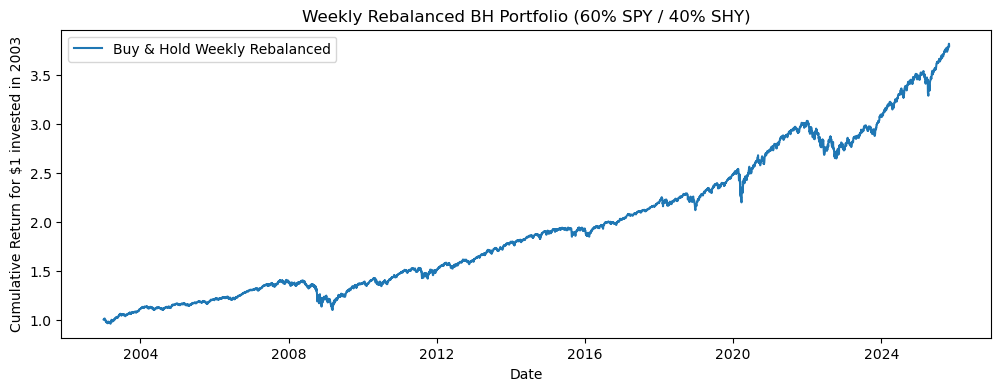

Final BH portfolio value: 3.795615039796364


In [7]:
bh_weights = pd.Series({"SHY": 0.6, "SPY": 0.4})
portfolio_value = 1.0
bh_cum_vals = []
print

rebalance_freq = 'W'  # weekly
rebalance_dates = returns.resample(rebalance_freq).last().index

w = bh_weights.copy()
for date, row in returns.iterrows():
    if date in rebalance_dates:
        # Reset weights to 60/40 weekly
        w = bh_weights.copy()

    # Compute daily return based on current weights
    r = (row[w.index] * w).sum()
    portfolio_value *= (1 + r)
    bh_cum_vals.append(portfolio_value)

# Create cumulative series
bh_cum_weekly = pd.Series(bh_cum_vals, index=returns.index)

# Plot
plt.figure(figsize=(12,4))
plt.plot(bh_cum_weekly, label="Buy & Hold Weekly Rebalanced")
plt.title("Weekly Rebalanced BH Portfolio (60% SPY / 40% SHY)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return for $1 invested in 2003")
plt.legend()
plt.show()
print("Final BH portfolio value:", bh_cum_weekly.iloc[-1])

## The CPPI strategy

In [12]:
# === PARAMETERS ===
# We will do the study for m=3 and floor=80% but you can change these values and we will vary them later to have different scenarios
m = 3 # risk multiplier
floor = 0.8  # capital floor
portfolio_value = 1.0
cppi_vals = []
weight_risky = []

# Choose rebalancing frequency: 'D' (daily), 'W' (weekly), 'ME' (monthly)
rebalance_freq = 'W'

# Create a mask for rebalancing dates
rebalance_dates = returns.resample(rebalance_freq).first().index

for date, row in returns.iterrows():
    if date in rebalance_dates:
        cushion = max(portfolio_value - floor, 0) / portfolio_value
        w = m * cushion
        w = np.clip(w, 0, 1)

    # Ensure r is scalar
    r = float(w * row["SPY"] + (1 - w) * row["SHY"])

    # Keep portfolio_value as float
    portfolio_value = float(portfolio_value * (1 + r))

    cppi_vals.append(portfolio_value)
    weight_risky.append(w)

strategy_cum = pd.Series(cppi_vals, index=returns.index)

print(type(strategy_cum))
print(strategy_cum.head())


plt.figure(figsize=(12,4))
plt.plot(strategy_cum.index, strategy_cum.values, label="CPPI Strategy")
plt.plot(bh_cum.index, bh_cum.values, label="Buy & Hold Strategy")
plt.title("CPPI vs Buy & Hold Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return for $1 invested in 2003")
plt.legend()
plt.show()

print("Final CPPI portfolio value:", strategy_cum.iloc[-1])

TypeError: cannot convert the series to <class 'float'>

## Performance and metrics comparison

In [87]:
"""
The metrics used to evaluate the performance of the strategy vs buy & hold are:
    - Sharpe Ratio
    - Max Drawdown
    - Kurtosis
    - Skewness
    - Annualized Volatility
# ADD VALUE AT RISK (VaR) LATER
We do both annualized and whole period metrics for comparison.
"""
metrics_strategy = performance_metrics(strategy_cum)
metrics_bh = performance_metrics(bh_cum)
print("CPPI Strategy Performance Metrics (2003-oct 2025):")
print(metrics_strategy)
print("Buy & Hold Performance Metrics (2003-oct 2025):")
print(metrics_bh)

CPPI Strategy Performance Metrics (2003-oct 2025):
Sharpe Ratio              0.663137
Max Drawdown             -0.551895
Kurtosis                 15.299638
Skewness                 -0.005132
Annualized Volatility     0.187052
VaR 95%                  -0.017088
CVaR 95%                 -0.028475
dtype: float64
Buy & Hold Performance Metrics (2003-oct 2025):
Sharpe Ratio              0.834330
Max Drawdown             -0.218582
Kurtosis                 15.002893
Skewness                  0.032850
Annualized Volatility     0.073310
VaR 95%                  -0.006578
CVaR 95%                 -0.011025
dtype: float64


## Key Performance Metrics
We compute:

- Annualized return  
- Annualized volatility  
- Sharpe ratio  
- Sortino ratio  
- Max drawdown  
- Calmar ratio  

In [ ]:
def ann_return(r):
    return (1+r).prod()**(252/len(r)) - 1

def ann_vol(r):
    return r.std() * np.sqrt(252)

def sharpe(r, rf=0):
    return (ann_return(r)-rf) / ann_vol(r)

def max_drawdown(cum):
    running_max = cum.cummax()
    dd = cum / running_max - 1
    return dd.min()

metrics = pd.DataFrame({
    "Buy & Hold": [
        ann_return(bh_returns),
        ann_vol(bh_returns),
        sharpe(bh_returns),
        max_drawdown(bh_cum)
    ],
    "Strategy": [
        ann_return(strategy_returns),
        ann_vol(strategy_returns),
        sharpe(strategy_returns),
        max_drawdown(strategy_cum)
    ]
}, index=["Ann Return","Ann Vol","Sharpe","Max Drawdown"])

metrics

## Drawdowns

In [ ]:
# Drawdown plots
bh_dd = bh_cum / bh_cum.cummax() - 1
st_dd = strategy_cum / strategy_cum.cummax() - 1

plt.figure(figsize=(12,5))
bh_dd.plot(label="Buy & Hold Drawdown")
st_dd.plot(label="Strategy Drawdown")
plt.legend()
plt.title("Drawdowns")
plt.show()

## Sensitivity Analysis
Try different parameters:  
- Different target vol levels  
- Different CPPI multipliers  
- Different lookback windows

Show their effect on:  
- Return  
- Sharpe  
- Drawdown  

In [ ]:
# Example loop for sensitivity:
vol_targets = [0.08, 0.10, 0.12, 0.15]
results = []

for tv in vol_targets:
    w = (tv / annual_vol).clip(0, 3)    
    r = w.shift(1)*returns["SPY"]
    results.append([tv, ann_return(r), sharpe(r), max_drawdown((1+r).cumprod())])

pd.DataFrame(results, columns=["Target Vol","Ann Ret","Sharpe","MaxDD"])


## Interpretation
Discuss:

- Why the strategy performed differently from Buy & Hold  
- Behavior in volatility spikes  
- Performance during crashes (COVID, 2022 inflation, etc.)  
- Leverage dynamics  
- Advantages and drawbacks

This is where human interpretation matters.


# Conclusion
Answer your research question:

**Does the strategy outperform Buy & Hold? Under what conditions?**  
Mention limitations and possible improvements.

This section must clearly include human reasoning.
